## 1.导入包

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
"""
网格搜索(Grid Search)和Optuna，找到模型的最佳超参数组合
网格搜索适用于超参数空间较小、离散且较少的情况，而Optuna适用于超参数空间较大、连续或离散且较多的情况
下面要做的事情：
1.换新的面心值标签，现在数据过拟合，训练集下降但是测试集上升或者波动
2.考虑正则化或者假如droput层来防止过拟合
3.考虑数据预处理中采用数据标准化，让数据均匀分布
4.用不用考虑损失函数，学习率,epoch,adam优化器及其四个参数，的修改，模型用不用再添加几层让模型变复杂些（batch-size越大，训练越快，不影响准确率）
5.早停法（Early Stopping）：在训练过程中监控验证集上的性能，一旦性能停止改善，在一定epoch后停止训练，并保存模型，以防止过拟合。可以参照外国那案例
6.数据集的比例，不一定4：1，也可以95：5，当数据集足够大时，这样可以增加训练集数量
"""

'\n网格搜索(Grid Search)和Optuna，找到模型的最佳超参数组合\n网格搜索适用于超参数空间较小、离散且较少的情况，而Optuna适用于超参数空间较大、连续或离散且较多的情况\n下面要做的事情：\n1.换新的面心值标签，现在数据过拟合，训练集下降但是测试集上升或者波动\n2.考虑正则化或者假如droput层来防止过拟合\n3.考虑数据预处理中采用数据标准化，让数据均匀分布\n4.用不用考虑损失函数，学习率,epoch,adam优化器及其四个参数，的修改，模型用不用再添加几层让模型变复杂些（batch-size越大，训练越快，不影响准确率）\n5.早停法（Early Stopping）：在训练过程中监控验证集上的性能，一旦性能停止改善，在一定epoch后停止训练，并保存模型，以防止过拟合。可以参照外国那案例\n6.数据集的比例，不一定4：1，也可以95：5，当数据集足够大时，这样可以增加训练集数量\n'

## 2.加载数据

"""
1.功能：
通过加载data和label文件，然后继续训练和预测。
定义了一个6层卷积神经网络模型。每个卷积层后面跟着一个 ReLU 激活函数。第七层只有卷积，没有relu。
输入数据n*64*64*2,这里的一个样本64*64可以看成一个图片格式（在此次任务中是速度，两者类似）
输出是n*64*64*4
"""
"""txt保存为numpy格式发现可以减少存储大小，约缩小成1/4
5.9G	./all_data.npy
12G	./all_label.npy
27G	./data_64x64x2.txt
53G	./label_a_2x64x65x2.txt
"""

In [3]:
# 直接加载npy文件为numpy格式
all_data = np.load('./data/all_data.npy')
# #直接加载npy文件为numpy格式,注意标签是面心值，不是a值
all_label = np.load('./data/all_centerFace_label.npy')

all_data = torch.tensor(all_data).float()
all_label = torch.tensor(all_label).float()


## 3.构建模型

In [4]:

class Net(nn.Module):
    def __init__(self, num_output_channels, dropout, layers, hidden_units):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()  # 用于存储每个层的列表

        # 添加卷积层、激活函数、dropout层
        for i in range(layers):
            if i == 0:
                self.layers.append(nn.Conv2d(2, hidden_units, kernel_size=3, stride=1, padding=1))
            else:
                self.layers.append(nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout))

        # 添加最后一层卷积层
        self.conv_final = nn.Conv2d(hidden_units, num_output_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # 运行每个层的forward方法
        for layer in self.layers:
            x = layer(x)

        x = self.conv_final(x)

        return x


## 4.模型训练与测试

In [5]:
def train(num_output_channels):
    
    import time
    start_time = time.time()

    # 定义一个batch包含的样本数目
    batch_size =128

    # 生成数据集
    x_train, x_test, y_train, y_test = train_test_split(all_data, all_label, test_size=0.2)

    # 设置种子数
    seed = 42
    torch.manual_seed(seed)

    # 划分数据集
    trainset = torch.utils.data.TensorDataset(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True)

    # 划分数据集
    testset = torch.utils.data.TensorDataset(x_test, y_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True)


    # 创建模型实例，并将模型移动到GPU设备上进行计算
    net = Net(num_output_channels,0.001,6,32).to(device)
    
    # 加速训练：如果有多个GPU，则使用DataParallel模块
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
        print("采用DataParallel加速，device_count个数为：",str(torch.cuda.device_count()))
        
    # 定义损失函数为均方误差
    criterion = nn.MSELoss()  # 将预测值与真实标签之间的差值求平方和，再除以样本数n来得到平均损失值

    # 定义优化器为Adam优化器,设置学习率为0.001
    optimizer = optim.Adam(net.parameters(),lr = 0.001)

    print('begin to train!!!')

    # 训练模型
    num_epochs = 20  # 训练轮数
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # 将参数的梯度设为0
            optimizer.zero_grad()

            # 前向传播+后向传播+优化
            outputs = net(inputs)
            # inputs:torch.Size([10, 2, 64, 64])
            # outputs:torch.Size([10, 4, 64, 64])
            """
            criterion：表示所选的损失函数，这里选择的是MSE均方误差
            outputs：模型在输入后得到的输出，它的形状是(batch_size, num_output_channels, height, width)
            """
            loss = criterion(outputs, labels)  # labels   :torch.Size([10, 120, 64, 64])
            loss.backward()  # 有了损失值后，就可以根据反向传播算法来更新模型参数，使得预测值更接近真实标签。
            optimizer.step()

            # 统计损失值
            running_train_loss += loss.item()  # 在训练过程中，目标就是通过反向传播和优化算法尽可能地减小该损失值，提高模型的性能。
            
                        # 每20个batch打印一次平均损失值，这里batch-size=10,相当于每100个样本打印一次loss
#             if i % 20 == 19:
#                 print('[epoch:  %d, batch:%5d] train loss: %.3f' %
#                       (epoch + 1, i + 1, running_train_loss))
        print("running_train_loss:",running_train_loss)        
        train_loss.append(running_train_loss)
            

                
        running_test_loss = 0.0
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            # 前向传播(预测)+后向传播+优化
            outputs = net(inputs)
            # inputs:torch.Size([10, 2, 64, 64])
            # outputs:torch.Size([10, 4, 64, 64])
            """
            criterion：表示所选的损失函数，这里选择的是MSE均方误差
            outputs：模型在输入后得到的输出，它的形状是(batch_size, num_output_channels, height, width)
            """
            loss = criterion(outputs, labels)  # labels   :torch.Size([10, 120, 64, 64])

            # 统计损失值
            running_test_loss += loss.item()  # 在训练过程中，目标就是通过反向传播和优化算法尽可能地减小该损失值，提高模型的性能。
            
        print("running_test_loss:",running_test_loss)        
        test_loss.append(running_test_loss)
        print("已完成第：",str(epoch+1),"个epoch!")


    end_time = time.time()
    process_time = end_time - start_time
    print(f"模型训练和测试共用了: {process_time} 秒！")#预处理data用了: 705.8258590698242 秒！
    print('all of tasks Finished')
    
    # 保存整个模型
    torch.save(net, './model/model_origin_20_01.pth')
    
    return train_loss,test_loss


"""
已完成第： 60 个epoch!
模型训练和测试共用了: 2325.386168241501 秒！
"""
train_loss,test_loss  = train(num_output_channels=4)
print(train_loss)
print(test_loss)
# 将数据写入文件，格式只能为二进制,二进制数据无法查看，想查看的话可以将其写入到txt里面或者用deebug查看
np.save('./data/lossa/loss_model_20_01.npy', np.array([train_loss,test_loss]))

采用DataParallel加速，device_count个数为： 4
begin to train!!!
running_train_loss: 2618.938800573349
running_test_loss: 624.4317009449005
已完成第： 1 个epoch!
running_train_loss: 2468.082384824753
running_test_loss: 609.1573833227158
已完成第： 2 个epoch!
running_train_loss: 2430.1384714841843
running_test_loss: 605.7278337478638
已完成第： 3 个epoch!
running_train_loss: 2414.4202716350555
running_test_loss: 601.0386171340942
已完成第： 4 个epoch!
running_train_loss: 2404.039754509926
running_test_loss: 598.4950227737427
已完成第： 5 个epoch!
running_train_loss: 2396.494523048401
running_test_loss: 597.8364828824997
已完成第： 6 个epoch!
running_train_loss: 2389.4938637018204
running_test_loss: 596.8641387224197
已完成第： 7 个epoch!
running_train_loss: 2382.8262991905212
running_test_loss: 595.0936875343323
已完成第： 8 个epoch!
running_train_loss: 2376.9073815345764
running_test_loss: 592.7681123018265
已完成第： 9 个epoch!
running_train_loss: 2373.350371360779
running_test_loss: 593.6779624223709
已完成第： 10 个epoch!
running_train_loss: 2367.66620

In [6]:
print(all_data.shape)
print(all_label.shape)


torch.Size([192000, 2, 64, 64])
torch.Size([192000, 4, 64, 64])


In [7]:
train_loss,test_loss = np.load('./data/lossa/loss_model_20_01.npy')
print(train_loss)

[2618.93880057 2468.08238482 2430.13847148 2414.42027164 2404.03975451
 2396.49452305 2389.4938637  2382.82629919 2376.90738153 2373.35037136
 2367.66620958 2363.92846215 2360.36637545 2357.5326612  2353.36322129
 2350.61249435 2348.07167637 2345.27684736 2341.91640353 2340.35887289]


# 5.可视化loss

[0.01704, 0.01607, 0.01582, 0.01572, 0.01565, 0.0156, 0.01555, 0.01551, 0.01547, 0.01545, 0.01541, 0.01538, 0.01536, 0.01535, 0.01532, 0.0153, 0.01529, 0.01527, 0.01524, 0.01523]


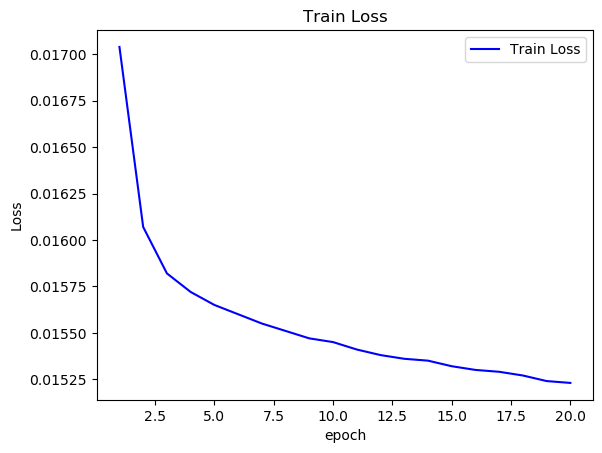

In [8]:
import matplotlib.pyplot as plt
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(train_loss) + 1)

train_loss = [round(int(a)/(all_data.shape[0]*0.8), 5) for a in train_loss]
print(train_loss)
# 绘制训练损失曲线
plt.plot(epoch, train_loss, 'b', label='Train Loss')

# 关闭科学计数法
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# 设置y轴范围下限为0
# plt.ylim(bottom=0)

# 设置图表标题和轴标签
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()

[624.43170094 609.15738332 605.72783375 601.03861713 598.49502277
 597.83648288 596.86413872 595.09368753 592.7681123  593.67796242
 590.33506393 590.56047022 589.23498082 587.804003   588.90325356
 588.53736854 585.46014845 585.6182301  586.50805604 583.30863619]


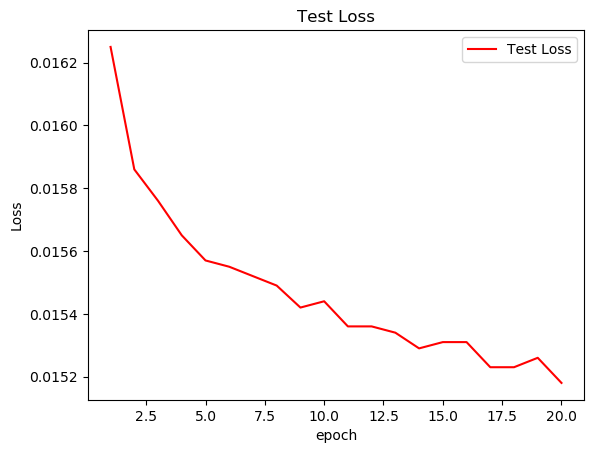

In [9]:
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(test_loss) + 1)
print(test_loss)
test_loss = [round(int(a)/(all_data.shape[0]*0.2), 5) for a in test_loss]


# 绘制测试损失曲线
plt.plot(epoch, test_loss, 'r', label='Test Loss')

# 设置图表标题和轴标签
plt.title('Test Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [10]:
# from torchsummary import summary
# # 将模型移动到适当的设备
# model = model.to(device)

# # 打印模型的概要信息
# summary(model,input_size=(2, 64, 64))

## 6.预测

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载模型
model = torch.load('./model/model_origin_300_01.pth', map_location=device)# from torchsummary import summary
# # 将模型移动到适当的设备

model = model.to(device)


In [12]:
# 设置模型为评估模式
model.eval()

# 输入数据进行预测
input_data =all_data[-10]  # 你的输入数据


#调整输入input的维度顺序,作为E，用于下面change_Label_to_a中(E-A)/(B-A)得到a值
matrix_64 = input_data.cpu()
matrix_64 = matrix_64.permute(1,2,0)  
print(matrix_64.shape)


# 转换为四维
input_data = input_data.unsqueeze(0)#用实际数据，数据格式为(1,2, 64, 64)，不能为2x64x64
# input_data = torch.randn(1,2, 64, 64)
print(input_data.shape)
input_tensor = input_data.to(device)

with torch.no_grad():
    output = model(input_tensor)##如果报错的话需要把网络的设计加上，里面涉及model(input)

# 打印预测结果
print(output)

torch.Size([64, 64, 2])
torch.Size([1, 2, 64, 64])


AttributeError: Caught AttributeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/user/.local/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/user/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_1706455/52758376.py", line 21, in forward
    for layer in self.layers:
  File "/home/user/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1130, in __getattr__
    raise AttributeError("'{}' object has no attribute '{}'".format(
AttributeError: 'Net' object has no attribute 'layers'


# 8.转换格式(label转为最终的weights)

In [ ]:
#将label面心值转为a值
def change_Label_to_a(all_vertical_edge_centers,all_horizontal_edge_centers):
    a_vertical = np.zeros((64, 65, 2))
    # a_vertical = np.random((64, 65, 2))
    a_horizontal = np.zeros((64, 65, 2))
    # a_horizontal = np.random.random((64, 65, 2))


    # 21. 求a:   横着的边，分两种情况，边缘（对称的）和非边缘的边.这里matrix_64要行列互换，因为横着时面心值是一列一列求得，竖着时是一行一行求的。
    for i in range(64):
        for j in range(65):
            if j == 0 or j == 64:
                # a_horizontal[i, j] = (all_horizontal_edge_centers[i, 0] - matrix_64[i, 0]) / (matrix_64[i, 63] - matrix_64[i, 0])#换之前
                a_horizontal[i, j] = (all_horizontal_edge_centers[i, 0] - matrix_64[0, i]) / (
                    matrix_64[63, i] - matrix_64[0, i])
            else:
                # aA=(1-a)B=E   a = (E-B)/(A-B) 其中：A为matrix_64[i,j]，B为matrix_64[i,j+1]
                # a_horizontal[i, j] = (all_horizontal_edge_centers[i, j] - matrix_64[i, j]) / (matrix_64[i, j-1] - matrix_64[i, j])
                a_horizontal[i, j] = (all_horizontal_edge_centers[i, j] - matrix_64[j, i]) / (
                    matrix_64[j - 1, i] - matrix_64[j, i])

    # 22. 求a:   竖着的边，分两种情况，边缘（对称的）和非边缘的边
    for i in range(64):
        for j in range(65):
            if j == 0 or j == 64:
                a_vertical[i, j] = (all_vertical_edge_centers[i, 0] - matrix_64[i, 0]) / (
                    matrix_64[i, 63] - matrix_64[i, 0])
            else:
                # aA=(1-a)B=E   a = (E-B)/(A-B) 其中：A为matrix_64[i,j]，B为matrix_64[i,j+1]
                # 2.错误matrix_64[i, j-1]) / (改成matrix_64[i, j]) / (
                a_vertical[i, j] = (all_vertical_edge_centers[i, j] - matrix_64[i, j]) / (
                    matrix_64[i, j - 1] - matrix_64[i, j])

    # # 若最终a对应的矩阵里面出现无穷，则将其替换为0.5.解决了分母为0的问题
    # a_vertical[np.isinf(a_vertical)] = 0.5
    # a_horizontal[np.isinf(a_horizontal)] = 0.5
    #这里64x65x2截成64x64x2,因为边框对称时值相同
    
    a_vertical = torch.tensor(a_vertical[:,:64,:])
    a_horizontal = torch.tensor(a_horizontal[:,:64,:])

    print(a_vertical.shape)
    print(a_horizontal.shape)
    return  a_vertical,a_horizontal

In [ ]:
#返回一个列表，里面嵌套两个子列表，第一个子列表存放的是内部的a值，第二个子列表存放的是边框的a值，
#且顺序为上（左到右），下（左到右），左（下到上），右（下到上）
def conversion_format(output):
    # 调整output的维度顺序
    output = output.permute(0,2,3,1)  
    print(output.shape)
    output = output[0]
    print(output.shape)
    # print(output)

    #将输出output拆成两个面心值
    all_vertical_edge_centers = output[:, :, 0:2].cpu()
    all_horizontal_edge_centers = output[:, :, 2:4].cpu()
    print(all_vertical_edge_centers.shape)
    print(all_horizontal_edge_centers.shape)

    
    a_vertical,a_horizontal  = change_Label_to_a(all_vertical_edge_centers,all_horizontal_edge_centers)    
    
    # 将前两个元素相加除以二得到一个元素(x+y/)2
    avg_vertical = (a_vertical[:, :, 0] + a_vertical[:, :, 1]) / 2
    # 将后两个元素相加除以二得到另一个元素
    avg_horizontal = (a_horizontal[:, :, 0] + a_horizontal[:, :, 1]) / 2

    # 重新组合成新的形状为(64, 64, 2)的张量
    new_avg_a_output = torch.stack([avg_vertical, avg_horizontal], dim=2)
    # 打印转换后的数据形状
    print(new_avg_a_output.shape)

    #返回两个求完平均的面心值,包括两个64*64矩阵，矩阵是求完平均后的a值，一个竖着的，一个横着的
    vertical_1d = new_avg_a_output[:, :, 0]
    horizontal_1d = new_avg_a_output[:, :,1]
    print(vertical_1d.shape)
    print(horizontal_1d.shape)
    
    
    border = []#存所有边框，四个边框
    left_border=[]#存左边框
    bottom_border = []#存下边框
    inner = []#存内部的面心值

    #下面将2个64x64面心值变换格式，返回指定的格式result
    for i in range(len(vertical_1d)): #两个for循环等价于for i in range(64):
        for j in range(len(vertical_1d[i])):
            if j ==0:#j=0添加边框
                #添加左边框
                left_border.append(vertical_1d[i][0])
                #添加下边框
                bottom_border.append(horizontal_1d[i][0])
            else: 
                if i !=  63:#当竖着的最后一行时，上面没有对应的横着的
                    inner.append(vertical_1d[i][j])#竖着的
    #                 print("{j-1},{i+1}",j-1,i+1)
                    inner.append(horizontal_1d[j-1][i+1])   #再横着的   
                    if j == 63:#如果j=63的话，还需要再加入最后一列的横着的边
                        inner.append(horizontal_1d[63][i+1])#当i=63,横着的加最后一列 
                else:#if i ==63 :
                    inner.append(vertical_1d[63][j])#当i=63,inner最后添加竖着的一行竖线

    inner = [tensor.cpu().numpy().tolist() for tensor in inner]#将一维列表里面的tensor元素转为numpy格式，并返回cpu版本
    # print(inner)
    four_border = [bottom_border,bottom_border,left_border,left_border]#顺序是上（左到右），下（左到右），左（下到上），右（下到上）
    border = [item.numpy().tolist() for sublist in four_border for item in sublist]
    result = [inner,border]
    print(len(result))
    return result



In [ ]:
result  = conversion_format(output)

In [ ]:
print(len(result[0]))
print(len(result[1]))
print(8064+64*2)

In [ ]:
print(result)

In [ ]:
count = sum(1 for num in result[0] if 0 < num < 1)
print(count)
print(count/len(result[0]))